### Imports

In [146]:
import pandas as pd
import numpy as np

from pyhhmm.gaussian import GaussianHMM
from pandas_datareader.data import DataReader

import yfinance as yf
yf.pdr_override()

import matplotlib.pyplot as plt

In [147]:
# Data Extraction

start_date = '2017-01-01'
end_date = '2022-06-01'
symbol = 'SPY'
data = DataReader(symbol, start_date, end_date) 

[*********************100%%**********************]  1 of 1 completed


In [148]:
# Manage Data and Add Features

data.drop(columns=['Close'], inplace=True)
df = data.copy()
df['returns'] = df['Adj Close']/df['Adj Close'].shift(1) - 1  
df['range'] = df['High']/df['Low'] -1

df.dropna(inplace=True)
print(len(df))
df.head()

1361


,Open,High,Low,Adj Close,Volume,returns,range
Date,,,,,,,
2017-01-04,225.619995,226.750000,225.610001,201.008301,78744400,0.005949,0.005053
2017-01-05,226.270004,226.580002,225.479996,200.848602,78379000,-0.000794,0.004879
2017-01-06,226.529999,227.750000,225.899994,201.567184,71559900,0.003578,0.008189
2017-01-09,226.910004,227.070007,226.419998,200.901855,46939700,-0.003301,0.002871
2017-01-10,226.479996,227.449997,226.009995,200.901855,63771900,0.000000,0.006371


In [149]:
# Add moving averages

df['ma_12'] = df['Adj Close'].rolling(window=50).mean()
df['ma_21'] = df['Adj Close'].rolling(window=200).mean()


In [150]:
# Structure Data for HMM

X_train = df[['returns', 'range']].iloc[:500]
X_test = df[['returns', 'range']].iloc[500:]

save_df = df.iloc[500:]

print(f"train length: {len(X_train)}")
print(f"test length: {len(X_test)}")

print(f"X_train from {X_train.index[0]} to {X_train.index[-1]}")
print(f"X_test from {X_test.index[0]} to {X_test.index[-1]}")
X_test

train length: 500
test length: 861
X_train from 2017-01-04 00:00:00 to 2018-12-28 00:00:00
X_test from 2018-12-31 00:00:00 to 2022-05-31 00:00:00


,returns,range
Date,,
2018-12-31,0.008759,0.010991
2019-01-02,0.001040,0.021387
2019-01-03,-0.023863,0.020109
2019-01-04,0.033496,0.024032
2019-01-07,0.007885,0.016926
...,...,...
2022-05-24,-0.007634,0.021165
2022-05-25,0.008835,0.019291
2022-05-26,0.019981,0.021559


### Train HMM

In [151]:
model = GaussianHMM(n_states=4, covariance_type="full", n_emissions=2)
model.train([np.array(X_train.values)])


(<pyhhmm.gaussian.GaussianHMM at 0x1ffd3ac1820>, 3636.7568594541763)

In [152]:
# Prediction

df_main = save_df.copy()
df_main.drop(columns=['High', 'Low'], inplace=True)

hmm_predictions = model.predict([np.array(X_test.values)])[0]
df_main['hmm_predictions'] = hmm_predictions
df_main.tail()

,Open,Adj Close,Volume,returns,range,ma_12,ma_21,hmm_predictions
Date,,,,,,,,
2022-05-24,392.559998,382.985077,91448800,-0.007634,0.021165,416.303298,430.901871,2
2022-05-25,392.309998,386.368713,91472900,0.008835,0.019291,415.768911,430.702596,2
2022-05-26,398.670013,394.088898,82168300,0.019981,0.021559,415.205728,430.536627,2
2022-05-27,407.910004,403.763489,84768700,0.024549,0.018837,414.730382,430.412628,2
2022-05-31,413.549988,401.497955,95937000,-0.005611,0.015682,414.116074,430.273403,2


### Run Backtest

In [153]:
# Add MA Signals

df_main.loc[df_main['ma_12'] > df_main['ma_21'], 'ma_signal'] = 1
df_main.loc[df_main['ma_12'] <= df_main['ma_21'], 'ma_signal'] = 0

In [199]:
# Add HMM Signals

favourable_states = [0,1]
hmm_values =df_main['hmm_predictions'].values
hmm_values = [1 if value in favourable_states else 0 for value in hmm_values]

df_main['hmm_signal'] = hmm_values

In [200]:
# Add Combined Signals

df_main['combined_signal'] = 0 
df_main.loc[(df_main['ma_signal'] == 1 ) & (df_main['hmm_signal'] == 1), 'combined_signal'] = 1
df_main['combined_signal'] = df_main['combined_signal'].shift(1) # shift to avoid look ahead bias


In [201]:
# Add Benchmark Returns

df_main['lrets_bench'] = np.log(df_main['Adj Close']/df_main['Adj Close'].shift(1))
df_main['lrets_bench_prod'] = df_main['lrets_bench'].cumsum()
df_main['lrets_bench_prod_exp'] =np.exp(df_main['lrets_bench_prod']) - 1 # normalizing bench returns

In [202]:
# Add Strategy Returns

df_main['lrets_strat'] = np.log(df_main['Open'].shift(-1)/df_main['Open']) * df_main['combined_signal']
df_main['lrets_strat_prod'] = df_main['lrets_strat'].cumsum()
df_main['lrets_strat_prod_exp'] =np.exp(df_main['lrets_strat_prod']) - 1 # normalizing strat returns

In [203]:
# Review Results
df_main.dropna(inplace=True)

df_main.tail()

,Open,Adj Close,Volume,returns,range,ma_12,ma_21,hmm_predictions,ma_signal,hmm_signal,combined_signal,lrets_bench,lrets_bench_prod,lrets_bench_prod_exp,lrets_strat,lrets_strat_prod,lrets_strat_prod_exp
Date,,,,,,,,,,,,,,,,,
2022-05-16,399.980011,389.013397,78622400,-0.004058,0.016021,419.176257,432.108586,2,0.0,0,0.0,-0.004066,0.497114,0.643969,0.0,0.540022,0.716044
2022-05-17,406.529999,397.015594,83029700,0.020570,0.014879,418.985469,431.987050,2,0.0,0,0.0,0.020362,0.517475,0.677787,-0.0,0.540022,0.716044
2022-05-18,403.500000,381.011292,117674500,-0.040312,0.033927,418.536243,431.768354,2,0.0,0,0.0,-0.041147,0.476329,0.610152,-0.0,0.540022,0.716044
2022-05-19,388.619995,378.677704,98510700,-0.006125,0.018160,417.823995,431.548437,2,0.0,0,0.0,-0.006144,0.470185,0.600291,0.0,0.540022,0.716044
2022-05-20,393.250000,378.843048,131432200,0.000437,0.043333,417.152471,431.315963,2,0.0,0,0.0,0.000437,0.470622,0.600989,-0.0,0.540022,0.716044


In [204]:
# Caclulate Sharpe Ratio

def calculate_sharpe(returns):
    N = 255
    NSQRT = np.sqrt(N)
    rf = 0.01
    mean = returns.mean() * N    
    sigma = returns.std() * NSQRT
    sharpe = (mean - rf)/ (sigma)
    return round(sharpe,2)

In [205]:
# Calculate Metrics

bench_returns = round(df_main['lrets_bench_prod_exp'][-1] * 100,2)
strat_returns = round(df_main['lrets_strat_prod_exp'][-1] * 100,2)

bench_sharpe = calculate_sharpe(df_main['lrets_bench'].values)
strat_sharpe = calculate_sharpe(df_main['lrets_strat'].values)

In [206]:
print(f"Benchmark Returns: {bench_returns}% Sharpe Ratio: {bench_sharpe}")
print(f"Strategy Returns: {strat_returns}% Sharpe Ratio: {strat_sharpe}")



Benchmark Returns: 60.1% Sharpe Ratio: 0.59
Strategy Returns: 71.6% Sharpe Ratio: 1.51


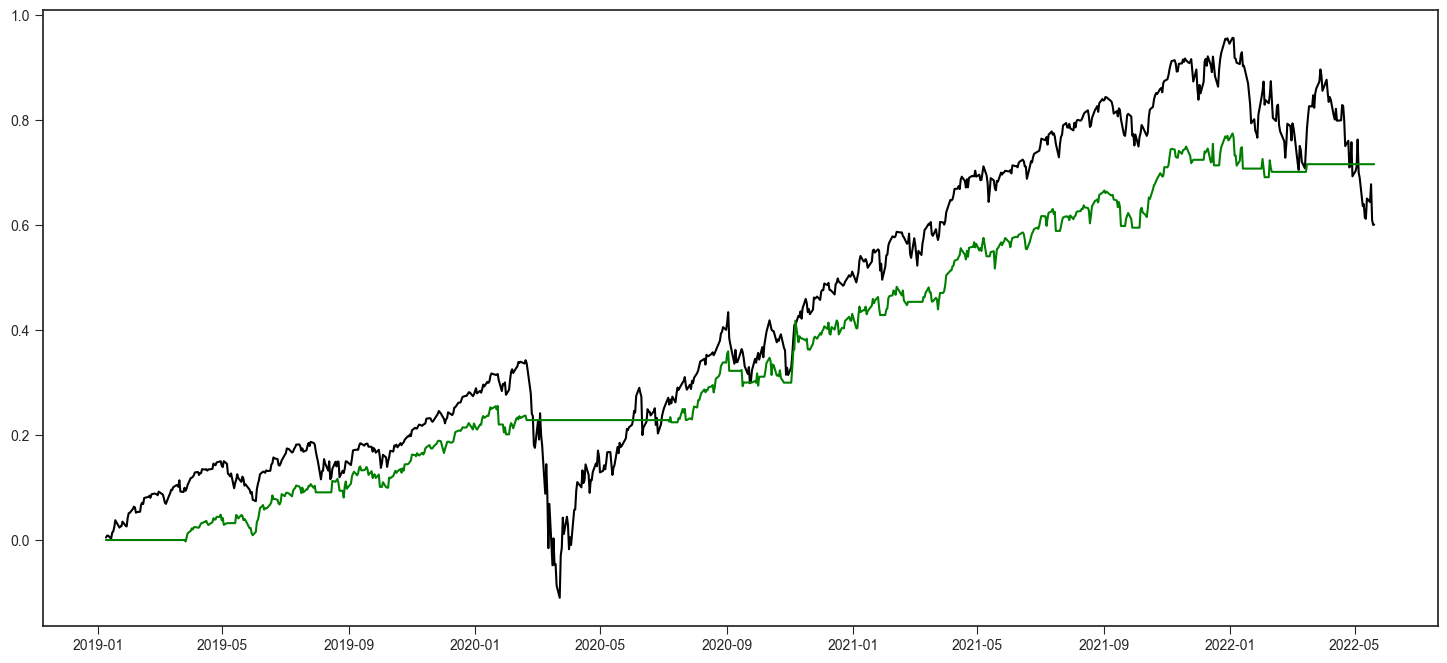

In [207]:
# Plot results
fig = plt.figure(figsize=(18,8))
plt.plot(df_main['lrets_bench_prod_exp'], color='black', label='Benchmark Returns')
plt.plot(df_main['lrets_strat_prod_exp'], color='green', label='Strategy Returns')



In [163]:
## Save Data

df_main.to_csv('data/HMM-SPY.csv')